In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers #Installing Huggingface transformers 

     |████████████████████████████████| 1.4MB 6.0MB/s 
     |████████████████████████████████| 890kB 37.4MB/s 
     |████████████████████████████████| 2.9MB 47.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ce7b6b8bd49200c6e46e221c58ca5fd09ec8604ab4d88795a2b2f3d812a6605c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import os
import requests
import tempfile
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import matplotlib.pyplot as plt
import re
import string
%matplotlib inline


import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Embedding, Dense, GRU
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.utils.layer_utils import count_params
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel

#import tensorflow_model_optimization as tfmot
#from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

# Read data

In [7]:
data = pd.read_excel('/content/drive/MyDrive/AC295 Final Proj/data/training_set_rel3.xls')
data = data[~np.isnan(data['domain1_score'].values)]

**As mentioned in milestone3, classification is not appropriate when we have large number of score levels. Instead of doing classification, we try regression. In this way, we can combine essays from all prompts. We rescale the scores to [0, 1] to train the model, then rescale back to examine performance of models (quadratic weighted kappa).**

# scaling

In [8]:
low_scale={1:2,2:1,3:0,4:0,5:0,6:0,7:0,8:0}
high_scale={1:12,2:6,3:3,4:3,5:4,6:4,7:30,8:60}

In [9]:
data['low_scale']=data.essay_set.map(low_scale)
data['high_scale']=data.essay_set.map(high_scale)
data['scaled_score']=(data.domain1_score-data.low_scale)/(data.high_scale-data.low_scale)

In [10]:
data

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,low_scale,high_scale,scaled_score
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0.600000
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0.700000
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0.500000
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0.800000
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12973,21626,8,In most stories mothers and daughters are eit...,17.0,18.0,NaN,35.0,NaN,NaN,NaN,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0,60,0.583333
12974,21628,8,I never understood the meaning laughter is th...,15.0,17.0,NaN,32.0,NaN,NaN,NaN,3.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0,60,0.533333
12975,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20.0,26.0,40.0,40.0,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,0,60,0.666667
12976,21630,8,Trippin' on fen...,20.0,20.0,NaN,40.0,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0,60,0.666667


In [48]:
data_X=data.essay.values
data_y=data.scaled_score.values.reshape(-1,1)
data_y_origin=data.domain1_score.values.reshape(-1,1)
essay_set=data.essay_set.values.reshape(-1,1)

train_X, test_X, train_y, test_y, train_y_origin, test_y_origin, train_essay_set, test_essay_set = train_test_split(data_X, data_y, data_y_origin, essay_set, test_size = 0.2, random_state = 295, stratify=data.essay_set)
train_data=(train_X,train_y)
test_data=(test_X,test_y)

In [28]:
def wordcount(seq):
  words = seq.split(' ')
  return len(words)
data.essay.map(wordcount).max()

1119

In [29]:
train_data

(array(['The author concludes this story by saying this statement because the author want you to feel like the character in the book is determined. The ator is trying to put across a statement saying  get through then try again. The character is not giving up, and she will get through the test eve though its hard.',
        'I think that computers are amazing. Computers are an amazing way to meat new pol online.',
        'Well since the cyclist is in a desert and out of mother he is probably not going to be happy. The "ghost towns" aren\'t really a boost of confidence either. The rugged hills made him angry too. The heat affected him the most.',
        ...,
        "There are so many resaons why taking a book, movie, or anything else off the shelves is wrong. If it is violent or sexual i can see why it shouldn't be on the shelves but if the reader doesn't like the book or movie, then don't read it or watch it find something else.     If everyone took a book of the shelf that they did

# Tokenization

In [30]:
'''
def standardize_text(input_text):
  # Convert to lower case
  lowercase = tf.strings.lower(input_text)
  # Remove HTML tags
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
  return tf.strings.regex_replace(
      stripped_html, "[%s]" % re.escape(string.punctuation), ""
  )
'''
max_features = 15000
sequence_length = 1200

text_data = tf.data.Dataset.from_tensor_slices(data.essay.values)

text_vectorizer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_vectorizer.adapt(text_data.batch(64))

def vectorize_text(text, label=None):
  text = tf.expand_dims(text, -1)
  text = text_vectorizer(text)
  if label is None:
    return text
  else:
    return text, label

In [49]:
batch_size = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = tf.data.Dataset.from_tensor_slices(train_data)
train_data = train_data.batch(batch_size)
#train_data = train_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
train_data = train_data.cache().prefetch(buffer_size=100)


val_data = tf.data.Dataset.from_tensor_slices(test_data)
val_data = val_data.batch(batch_size)
#val_data = val_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=100)


In [32]:
train_data

<PrefetchDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float64)>

# Utils functions

In [33]:
def evaluate_model(model,test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('MSE')
  # Plot all metrics
  for metric in ["mse","val_mse"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print("Evaluation Results:", evaluation_results)

In [34]:
def QWK(model):
  #calculate quadratic weighted kappa
  df=pd.DataFrame(model.predict(val_data),columns=['pred_scaled'])
  df['essay_set']=test_essay_set
  df['low_scale']=df.essay_set.map(low_scale)
  df['high_scale']=df.essay_set.map(high_scale)
  df['pred_origin']=df['pred_scaled']*(df.high_scale-df.low_scale)+df.low_scale
  df['pred_origin_rounded']=df['pred_origin'].round(0).astype(int)
  df['true_origin']=test_y_origin

  QWK=df.groupby('essay_set').apply(lambda x: cohen_kappa_score(x['pred_origin_rounded'], x['true_origin'], weights='quadratic'))
  return QWK


In [35]:
def QWK_bert(model):
  #calculate quadratic weighted kappa
  df=pd.DataFrame(model.predict(validation_data),columns=['pred_scaled'])
  df['essay_set']=test_essay_set
  df['low_scale']=df.essay_set.map(low_scale)
  df['high_scale']=df.essay_set.map(high_scale)
  df['pred_origin']=df['pred_scaled']*(df.high_scale-df.low_scale)+df.low_scale
  df['pred_origin_rounded']=df['pred_origin'].round(0).astype(int)
  df['true_origin']=test_y_origin

  QWK=df.groupby('essay_set').apply(lambda x: cohen_kappa_score(x['pred_origin_rounded'], x['true_origin'], weights='quadratic'))
  return QWK


# Building models

## 1. FFNN model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                76864     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 79,489
Trainable params: 79,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
82/82 [==============================] - 1s 13ms/step - loss: 28.7966 - mse: 0.2571 - val_loss: 9.0411 - v

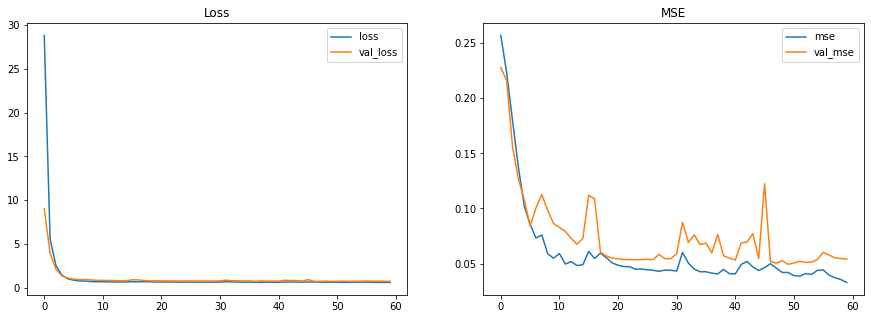

21/21 [==============================] - 0s 8ms/step - loss: 0.7665 - mse: 0.0540
Evaluation Results: [0.7665430903434753, 0.053962696343660355]


In [50]:
K.clear_session()
model_ffnn = Sequential()
model_ffnn.add(layers.Input(shape = (1,),dtype=tf.string))
model_ffnn.add(text_vectorizer)
model_ffnn.add(layers.Dense(64, activation = 'relu'))
model_ffnn.add(layers.Dense(32, activation = 'relu'))
model_ffnn.add(layers.Dense(16, activation = 'relu'))
model_ffnn.add(layers.Dense(1, activation = 'sigmoid')) # scaled score in [0, 1]

loss = tf.keras.losses.binary_crossentropy
optimizer = optimizers.Adam(lr = 0.001)
metrics=['mse']
model_ffnn.compile(loss= loss, optimizer = optimizer, metrics = metrics)
model_ffnn.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto'
)

history_ffnn=model_ffnn.fit(train_data, validation_data = val_data, callbacks=early_stopping, epochs = 100, verbose = 1)
evaluate_model(model_ffnn,val_data,history_ffnn)

## 2. Embedding + LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,120,501
Trainable params: 3,120,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
82/82 [==============================] - 11s 130ms/step - loss: 0.6597 - mse: 0.0456 - val_loss: 0.6353 - val_mse: 0.0326
Epoch 2/50
82/82 [==============================] - 9s 114ms/step - loss: 0.6234 - mse: 0.0288 - val_loss: 0.65

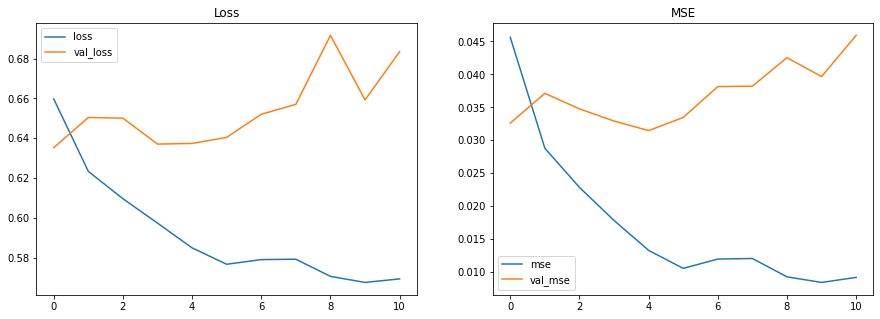

21/21 [==============================] - 1s 40ms/step - loss: 0.6353 - mse: 0.0326
Evaluation Results: [0.6352663636207581, 0.03259623050689697]


In [37]:
K.clear_session()
latent_dim=200

model_em_lstm=Sequential()
model_em_lstm.add(layers.Input(shape = (1,),dtype=tf.string))
model_em_lstm.add(text_vectorizer)
model_em_lstm.add(Embedding(max_features, latent_dim, input_length=sequence_length, mask_zero=True))
model_em_lstm.add(LSTM(100))
#model_em_lstm.add(layers.Dropout(0.3))
model_em_lstm.add(layers.Dense(1, activation = 'sigmoid'))

model_em_lstm.summary()
loss = tf.keras.losses.binary_crossentropy
optimizer = optimizers.RMSprop(learning_rate= 0.001)
optimizer = optimizers.Adam(lr = 0.001)
metrics=['mse']
model_em_lstm.compile(loss= loss, optimizer = optimizer, metrics = metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',restore_best_weights=True
)

history_em_lstm=model_em_lstm.fit(train_data, validation_data = val_data, callbacks=early_stopping, epochs = 50, verbose = 1)
evaluate_model(model_em_lstm,val_data,history_em_lstm)

## 3. Embedding + GRU

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 200)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 100)               90600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,090,701
Trainable params: 3,090,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
82/82 [==============================] - 10s 125ms/step - loss: 0.6679 - mse: 0.0495 - val_loss: 0.6461 - val_mse: 0.0374
Epoch 2/100
82/82 [==============================] - 9s 113ms/step - loss: 0.6311 - mse: 0.0323 - val_loss: 0.

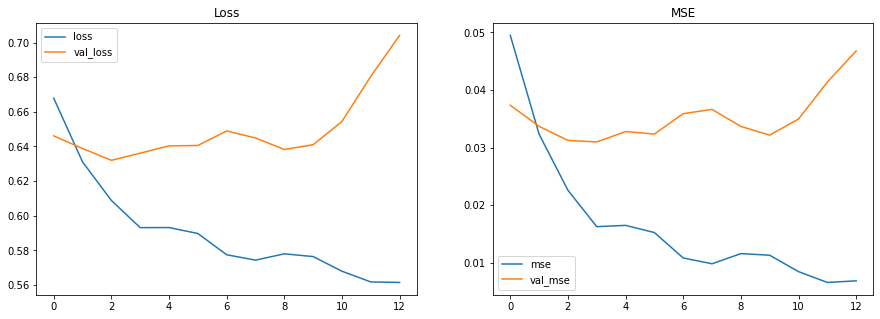

21/21 [==============================] - 1s 39ms/step - loss: 0.6320 - mse: 0.0312
Evaluation Results: [0.632003128528595, 0.031248876824975014]


In [38]:
K.clear_session()
latent_dim=200

model_em_gru=Sequential()
model_em_gru.add(layers.Input(shape = (1,),dtype=tf.string))
model_em_gru.add(text_vectorizer)
model_em_gru.add(Embedding(max_features, latent_dim, input_length=sequence_length, mask_zero=True))
model_em_gru.add(GRU(100))
model_em_gru.add(layers.Dense(1, activation = 'sigmoid'))

model_em_gru.summary()
loss = tf.keras.losses.binary_crossentropy
optimizer = optimizers.Adam(lr = 0.001)
metrics=['mse']
model_em_gru.compile(loss= loss, optimizer = optimizer, metrics = metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',restore_best_weights=True
)

history_em_gru=model_em_gru.fit(train_data, validation_data = val_data, callbacks=early_stopping, epochs = 100, verbose = 1)
evaluate_model(model_em_gru,val_data, history_em_gru)

## 4. Using pre-trained embedding 

### Downloading glove

In [39]:
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    
    if packet_file.endswith(".tar.gz"):
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

download_file("https://github.com/shivasj/dataset-store/releases/download/v3.0/glove.6B.100d.txt.zip", base_path="embedding", extract=True)

path_to_glove_file = '/content/embedding/glove.6B.100d.txt'
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

#num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Get Vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
print("Vocabulary Size:",vocabulary_size)
# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))


# Prepare embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Vocabulary Size: 15000
Converted 11723 words (3277 misses)


### Glove + LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,580,501
Trainable params: 80,501
Non-trainable params: 1,500,000
_________________________________________________________________
Epoch 1/100
82/82 [==============================] - 7s 79ms/step - loss: 0.6763 - mse: 0.0534 - val_loss: 0.6989 - val_mse: 0.0627
Epoch 2/100
82/82 [==============================] - 6s 67ms/step - loss: 0.6612 - mse: 0.0462 - val_loss: 

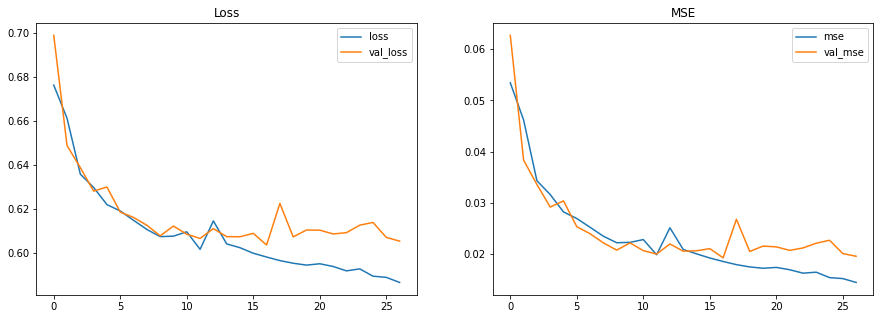

21/21 [==============================] - 1s 33ms/step - loss: 0.6036 - mse: 0.0193
Evaluation Results: [0.6035875678062439, 0.019296372309327126]


In [40]:
K.clear_session()
latent_dim=200

model_glo_lstm=Sequential()
model_glo_lstm.add(layers.Input(shape = (1,),dtype=tf.string))
model_glo_lstm.add(text_vectorizer)
model_glo_lstm.add(Embedding(max_features, 
                            embedding_dim, 
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            trainable=False,
                            name="embedding", mask_zero = True))
model_glo_lstm.add(LSTM(100))
model_glo_lstm.add(layers.Dense(1, activation = 'sigmoid'))

model_glo_lstm.summary()
loss = tf.keras.losses.binary_crossentropy
optimizer = optimizers.RMSprop(learning_rate= 0.001)
metrics=['mse']
model_glo_lstm.compile(loss= loss, optimizer = optimizer, metrics = metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True
)

history_glo_lstm=model_glo_lstm.fit(train_data, validation_data = val_data, callbacks=early_stopping, epochs = 100, verbose = 1)
evaluate_model(model_glo_lstm,val_data,history_glo_lstm)

### Glove + GRU

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 1200)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1200, 100)         1500000   
_________________________________________________________________
gru (GRU)                    (None, 1200, 64)          31872     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,541,313
Trainable params: 41,313
Non-trainable params: 1,500,000
_________________________________________________________________
Epoch 1/100
82/82 [==============================] - 10s 120ms/step - loss: 0.6756 - mse: 0.0532 - val_loss

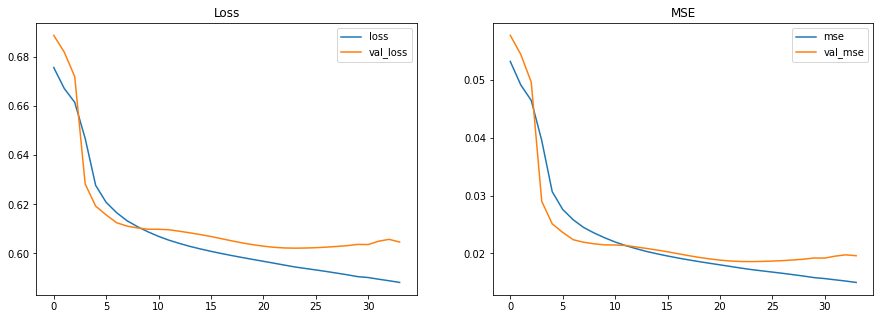

21/21 [==============================] - 1s 49ms/step - loss: 0.6022 - mse: 0.0186
Evaluation Results: [0.6021736264228821, 0.01858583465218544]


In [41]:
K.clear_session()
latent_dim=200

model_glo_gru=Sequential()
model_glo_gru.add(layers.Input(shape = (1,),dtype=tf.string))
model_glo_gru.add(text_vectorizer)
model_glo_gru.add(Embedding(max_features, 
                            embedding_dim, 
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            trainable=False,
                            name="embedding", mask_zero = True))
model_glo_gru.add(GRU(64, return_sequences=True))
model_glo_gru.add(GRU(32))
model_glo_gru.add(layers.Dense(1, activation = 'sigmoid'))

model_glo_gru.summary()
loss = tf.keras.losses.binary_crossentropy
optimizer = optimizers.RMSprop(learning_rate= 0.0006)
metrics=['mse']
model_glo_gru.compile(loss= loss, optimizer = optimizer, metrics = metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True
)

history_glo_gru=model_glo_gru.fit(train_data, validation_data = val_data, callbacks=early_stopping, epochs = 100, verbose = 1)
evaluate_model(model_glo_gru,val_data,history_glo_gru)#

## BERT

In [20]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
train_X = tokenizer.batch_encode_plus(
                      train_X,
                      return_tensors='tf',
                      add_special_tokens = True, # add [CLS], [SEP]
                      return_token_type_ids=True,
                      padding='max_length',
                      max_length=512, # max length of the text that can go to BERT (<=512)
                      return_attention_mask = True,
                      truncation='longest_first'
                  )
test_X = tokenizer.batch_encode_plus(
                      test_X,
                      return_tensors='tf',
                      add_special_tokens = True, # add [CLS], [SEP]
                      return_token_type_ids=True,
                      padding='max_length',
                      max_length=512, # max length of the text that can go to BERT (<=512)
                      return_attention_mask = True,
                      truncation='longest_first'
                  )

In [21]:
batch_size = 64 # You can try higher values but may run into OOM errors depending on which GPU you are using
train_shuffle_buffer_size = 800
validation_shuffle_buffer_size = 200

train_data = tf.data.Dataset.from_tensor_slices((dict(train_X), train_y))
validation_data = tf.data.Dataset.from_tensor_slices((dict(test_X), test_y))

train_data = train_data.batch(batch_size)
#train_data = train_data.shuffle(train_shuffle_buffer_size)
train_data = train_data.cache().prefetch(buffer_size=train_shuffle_buffer_size)

validation_data = validation_data.batch(batch_size)
#validation_data = validation_data.shuffle(validation_shuffle_buffer_size)
validation_data = validation_data.cache().prefetch(buffer_size=validation_shuffle_buffer_size)

In [ ]:
train_data

<PrefetchDataset shapes: ({input_ids: (None, 512), token_type_ids: (None, 512), attention_mask: (None, 512)}, (None, 1)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.float64)>

In [23]:
# Build BERT model
max_len = 512
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name = 'input_ids')
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name = 'token_type_ids')
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name = 'attention_mask')
encoder = TFBertModel.from_pretrained("bert-base-uncased")
encoder.trainable=False
embedding = encoder(
    input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
)[1]
embedding_flatten = layers.Flatten(name="embedding_flatten")(embedding)
text_dropout=layers.Dropout(0.2)(embedding_flatten)
bert_dense = layers.Dense(256, name="bert_dense", activation = 'relu')(text_dropout)
intermediate_dense = layers.Dense(32, name = "intermediate_dense", activation = 'relu')(bert_dense)
output = layers.Dense(1, activation = 'sigmoid')(intermediate_dense)

inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
bert_model = keras.Model(inputs= inputs, outputs= output,name='BERT_Model')

bert_model.summary()


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERT_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]    

In [ ]:
optimizer = optimizers.RMSprop(0.0001)
loss = losses.binary_crossentropy
metrics=['mse']
bert_model.compile(optimizer=optimizer, loss = loss, metrics = metrics)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto'
)

bert_result = bert_model.fit(train_data, validation_data = validation_data, callbacks=early_stopping, epochs = 100, verbose = 1)

Epoch 1/100
163/163 [==============================] - 299s 2s/step - loss: 0.6600 - mse: 0.0455 - val_loss: 0.6414 - val_mse: 0.0350
Epoch 2/100
163/163 [==============================] - 297s 2s/step - loss: 0.6481 - mse: 0.0399 - val_loss: 0.6384 - val_mse: 0.0337
Epoch 3/100
163/163 [==============================] - 297s 2s/step - loss: 0.6443 - mse: 0.0382 - val_loss: 0.6328 - val_mse: 0.0312
Epoch 4/100
163/163 [==============================] - 297s 2s/step - loss: 0.6408 - mse: 0.0366 - val_loss: 0.6309 - val_mse: 0.0303
Epoch 5/100
163/163 [==============================] - 297s 2s/step - loss: 0.6388 - mse: 0.0356 - val_loss: 0.6254 - val_mse: 0.0278
Epoch 6/100
163/163 [==============================] - 297s 2s/step - loss: 0.6385 - mse: 0.0355 - val_loss: 0.6273 - val_mse: 0.0287
Epoch 7/100
163/163 [==============================] - 297s 2s/step - loss: 0.6368 - mse: 0.0348 - val_loss: 0.6247 - val_mse: 0.0275
Epoch 8/100
163/163 [==============================] - 297s 2s

In [24]:
bert_model.load_weights('/content/drive/MyDrive/AC295 Final Proj/models/BERT_Model.h5')

# Comparison of models

In [42]:
QWK_ffnn=QWK(model_ffnn)
QWK_em_lstm=QWK(model_em_lstm)
QWK_em_gru=QWK(model_em_gru)
QWK_glo_lstm=QWK(model_glo_lstm)
QWK_glo_gru=QWK(model_glo_gru)

In [45]:
QWK_bert_result=QWK_bert(bert_model)

In [52]:
QWK_summary=pd.DataFrame(columns=['Essay set ' + str(i) for i in range(1,9)])
QWK_summary.loc['FFNN']=QWK_ffnn.values
QWK_summary.loc['Embedding + LSTM']=QWK_em_lstm.values
QWK_summary.loc['Embedding + GRU']=QWK_em_gru.values
QWK_summary.loc['Glove + LSTM']=QWK_glo_lstm.values
QWK_summary.loc['Glove + GRU']=QWK_glo_gru.values
QWK_summary.loc['BERT']=QWK_bert_result.values

QWK_summary['Avg QWK']=QWK_summary.mean(axis=1)

In [53]:
QWK_summary

,Essay set 1,Essay set 2,Essay set 3,Essay set 4,Essay set 5,Essay set 6,Essay set 7,Essay set 8,Avg QWK
FFNN,0.294252,0.122350,0.567171,0.530039,0.532715,0.342619,0.333485,0.162455,0.360636
Embedding + LSTM,0.479017,0.299045,0.296402,0.556103,0.475475,0.516581,0.383937,0.438777,0.430667
Embedding + GRU,0.414639,0.248768,0.520060,0.684207,0.577488,0.686443,0.435944,0.304459,0.484001
Glove + LSTM,0.658382,0.562710,0.669441,0.781211,0.771155,0.777059,0.661381,0.348823,0.653770
Glove + GRU,0.699782,0.597902,0.660300,0.800982,0.799006,0.806195,0.681931,0.414676,0.682597
BERT,0.507637,0.294903,0.390665,0.546719,0.605543,0.440768,0.684060,0.594885,0.508147
